In [44]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import tqdm

In [37]:
pretrain_entities = np.load("/data/katie_kang/pretraining_entities/the_pile_entity_map.npz")

In [40]:
pretrain_entities['http://dbpedia.org/resource/Horseshoes']

array([151205893, 151726105, 151667745, ...,  81470969,  81907706,
        81756155], dtype=int32)

In [83]:
with open("/data/katie_kang/qa_entities/trivia_qa_unfiltered.nocontext_validation_entities.jsonl") as f:
    data = f.readlines()

In [84]:
len(data)

11313

In [81]:
from datasets import load_dataset

data2  = load_dataset("trivia_qa", "rc.nocontext")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/47 [00:00<?, ?it/s]

In [82]:
len(data2['validation'])

17944

In [54]:
num_intersections = []
for i in tqdm.tqdm(range(len(data))):
    result = json.loads(data[i])
    a = []

    for x in result['q_entities']:
        try:
            a.append(pretrain_entities[x['URI']])
        except:
            print(x['URI'])
    if len(a) >0:
        a = np.concatenate(a)
        
    b = []
    for x in result['a_entities']:
        try:
            b.append(pretrain_entities[x['URI']])
        except:
            print(x['URI'])
    if len(b) >0:
        b = np.concatenate(b)
    num_intersections.append(len(list(set(a) & set(b))))

 25%|██▌       | 2858/11313 [2:21:52<5:54:05,  2.51s/it] 

http://dbpedia.org/resource/Wild_Thing_(The_Troggs_song)


 32%|███▏      | 3578/11313 [2:59:19<4:07:31,  1.92s/it]  

http://dbpedia.org/resource/Nemesis_(video_game)


 82%|████████▏ | 9265/11313 [7:56:34<36:12,  1.06s/it]    

http://dbpedia.org/resource/Magdi_Yacoub


 90%|█████████ | 10191/11313 [8:33:00<1:29:22,  4.78s/it]

http://dbpedia.org/resource/Mood_(song)


100%|██████████| 11313/11313 [9:27:07<00:00,  3.01s/it]   


In [56]:
np.save("num_pretrain_entities/triviaqa_validation.npy", num_intersections)

In [63]:
len(num_intersections)

11313

In [64]:
len(data)

11313

(array([1.0922e+04, 1.1600e+02, 1.0200e+02, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5300e+02, 1.6000e+01]),
 array([       0. ,  3275789.8,  6551579.6,  9827369.4, 13103159.2,
        16378949. , 19654738.8, 22930528.6, 26206318.4, 29482108.2,
        32757898. ]),
 <BarContainer object of 10 artists>)

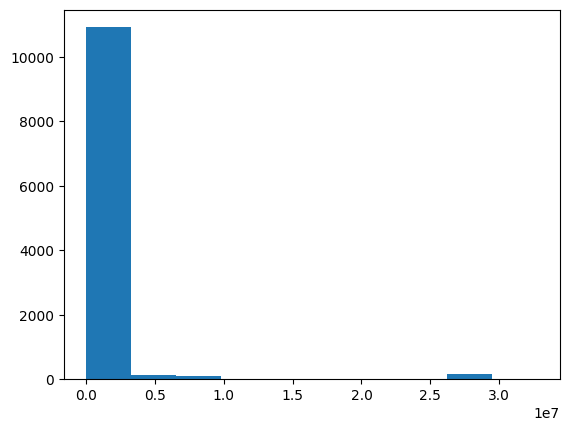

In [62]:
idxs = np.where(np.array(num_intersections)!=-1)[0]

plt.hist(np.array(num_intersections)[idxs])

In [61]:
idxs

array([    0,     1,     2, ..., 11310, 11311, 11312])

(array([9.811e+03, 1.320e+03, 1.650e+02, 1.400e+01, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <BarContainer object of 8 artists>)

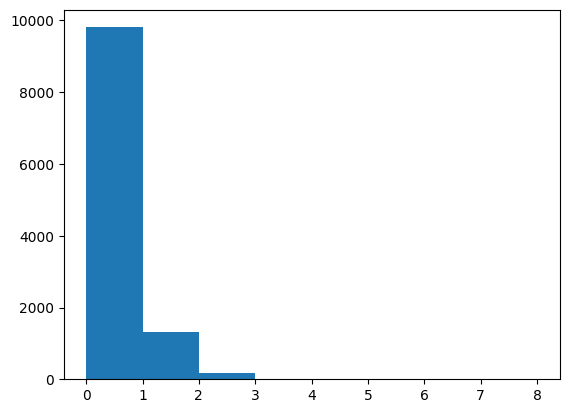

In [34]:
num_intersections = np.array(num_intersections)
(num_intersections==0).sum()/len(num_intersections)

0.8672323875187837

In [86]:
model_path = "ckpts/sft_triviaqa_llama7B/checkpoint_20000/hf_model/"

sft_answer_log_probs_mean_all = np.load(os.path.join(model_path, "test_answer_log_probs_mean_all.npy"))

sft_answers_correct = np.load(os.path.join(model_path, "test_answers_correct.npy"))


In [87]:
len(sft_answers_correct)

11313

(array([2.0000e+00, 2.0000e+00, 0.0000e+00, 1.2000e+01, 5.1000e+01,
        2.2300e+02, 5.7000e+02, 1.4730e+03, 4.1160e+03, 1.1495e+04]),
 array([-1.16655135e+00, -1.04991640e+00, -9.33281444e-01, -8.16646490e-01,
        -7.00011536e-01, -5.83376582e-01, -4.66741628e-01, -3.50106674e-01,
        -2.33471720e-01, -1.16836766e-01, -2.01811694e-04]),
 <BarContainer object of 10 artists>)

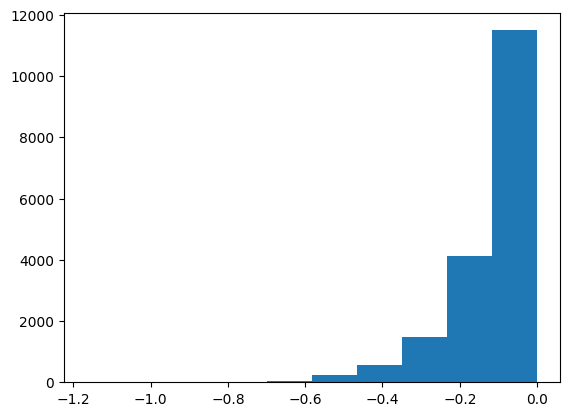

In [88]:
plt.hist(sft_answer_log_probs_mean_all)

In [151]:

sft_answer_log_probs_mean_all = np.array(num_intersections)
percentiles = [0, 5, 10, 20, 40, 60, 80, 100]
nll_bins = np.percentile(-sft_answer_log_probs_mean_all, percentiles)

nll_bins = -1*np.array([np.inf, 2e7, 1e6, 1e4, 1e2, 0])

In [152]:
np.max(sft_answer_log_probs_mean_all)

32757898

In [153]:
accuracies = []

for i in range(len(nll_bins) - 1):
    bin_lower = nll_bins[i]
    bin_upper = nll_bins[i + 1]

    indices = np.where((-sft_answer_log_probs_mean_all >= bin_lower) & (-sft_answer_log_probs_mean_all < bin_upper))[0]
    print(len(indices))

    accuracies.append(np.mean(sft_answers_correct[indices]))

169
702
4699
3375
295


In [154]:
accuracies

[0.8165680473372781,
 0.7008547008547008,
 0.6403490104277506,
 0.562962962962963,
 0.38305084745762713]

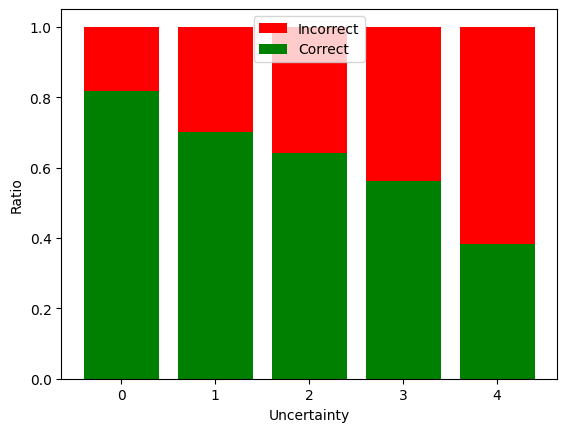

In [155]:
plt.bar([0, 1, 2, 3, 4], [1, 1, 1, 1, 1], color="red", label = "Incorrect")
plt.bar([0, 1, 2, 3, 4], accuracies, color="green", label = "Correct")

plt.xlabel("Uncertainty")
plt.ylabel("Ratio")
plt.legend()

In [156]:
model_path = "ckpts/sft2_triviaqa_llama7B_t0.9/checkpoint_20000/hf_model/"

sft2_answers_correct = np.load(os.path.join(model_path, "test_answers_correct.npy"))
sft2_answers_dont_know = np.load(os.path.join(model_path, "test_answers_dont_know.npy"))

In [95]:
sft2_answers_correct

idxs = np.where(sft2_answers_dont_know == 0)[0]
sft2_answers_correct[idxs].mean()

# (1- sft2_answers_dont_know - sft2_answers_correct).mean()

0.7418193717277487

In [96]:
(1- sft_answers_correct).mean()

0.4232299124900557

In [157]:
accuracies = []
dont_know_frac = []

for i in range(len(nll_bins) - 1):
    bin_lower = nll_bins[i]
    bin_upper = nll_bins[i + 1]

    indices = np.where((-sft_answer_log_probs_mean_all >= bin_lower) & (-sft_answer_log_probs_mean_all < bin_upper))[0]

    accuracies.append(np.mean(sft2_answers_correct[indices]))
    dont_know_frac.append(np.mean(sft2_answers_dont_know[indices]))

accuracies = np.array(accuracies)
dont_know_frac = np.array(dont_know_frac)
selective_accuracies = accuracies/(1-np.array(dont_know_frac))

In [158]:
accuracies/(1-np.array(dont_know_frac))

array([0.87969925, 0.82182628, 0.78187071, 0.72619048, 0.57291667])

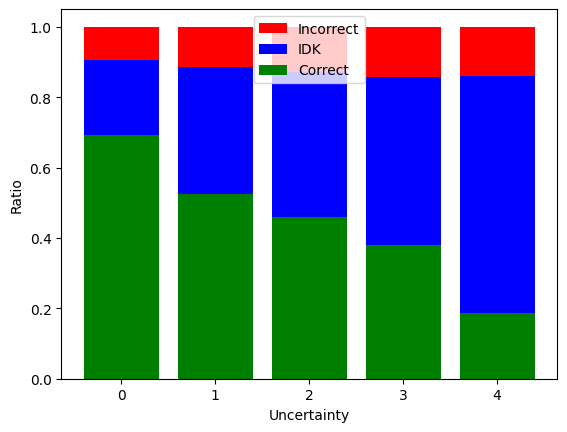

In [159]:
plt.bar([0, 1, 2, 3, 4], [1, 1, 1, 1, 1], color="red", label="Incorrect")
plt.bar([0, 1, 2, 3, 4], accuracies+dont_know_frac, color="blue", label="IDK")

plt.bar([0, 1, 2, 3, 4], accuracies, color="green", label="Correct")
plt.xlabel("Uncertainty")
plt.ylabel("Ratio")

plt.legend()



In [81]:
accuracies

array([0.85511284, 0.71384787, 0.52090301, 0.24331104, 0.03705768])

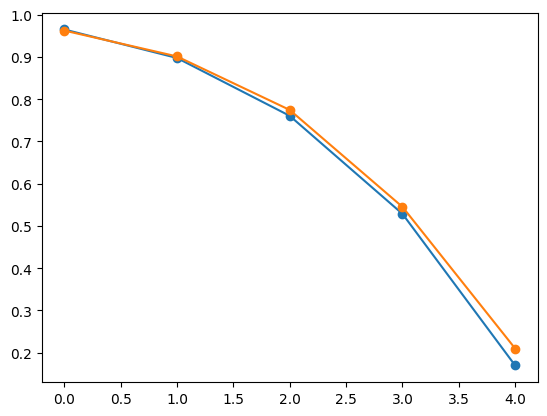

In [74]:



plt.plot(accuracies, "o-")

plt.plot(selective_accuracies, "o-")